### Instaling pakages and importing

In [ ]:
!pip install segmentation-models-3D
!pip install split-folders

In [ ]:
import numpy as np
import nibabel as nib
import glob
import cv2
import pandas as pd

import matplotlib.pyplot as plt
from tifffile import imsave
import splitfolders
import os
from sklearn.preprocessing import MinMaxScaler
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

import segmentation_models_3D as sm

scaler = MinMaxScaler()

## Converting Data(images and masks) in numpy array and Spliting in train and validation.


In [ ]:

TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab/MICCAI_BraTS2020_TrainingData'

# Train images lists 
# t1_list is not required becuase it does not show much data
train_t2_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t2.nii'))
train_t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t1ce.nii'))
train_t1_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t1.nii'))
train_flair_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*flair.nii'))
train_mask_list = sorted(glob.glob(TRAIN_DATASET_PATH +'/*/*seg.nii'))


for img1 in range(5):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img1)
      
    train_image_t2=nib.load(train_t2_list[img1]).get_fdata()
    train_image_t2=scaler.fit_transform(train_image_t2.reshape(-1, train_image_t2.shape[-1])).reshape(train_image_t2.shape)
   
    train_image_t1ce=nib.load(train_t1ce_list[img1]).get_fdata()
    train_image_t1ce=scaler.fit_transform(train_image_t1ce.reshape(-1, train_image_t1ce.shape[-1])).reshape(train_image_t1ce.shape)
   
    train_image_t1=nib.load(train_t1_list[img1]).get_fdata()
    train_image_t1=scaler.fit_transform(train_image_t1.reshape(-1, train_image_t1.shape[-1])).reshape(train_image_t1.shape)

    train_image_flair=nib.load(train_flair_list[img1]).get_fdata()
    train_image_flair=scaler.fit_transform(train_image_flair.reshape(-1, train_image_flair.shape[-1])).reshape(train_image_flair.shape)
        
    train_mask=nib.load(train_mask_list[img1]).get_fdata()
    train_mask=train_mask.astype(np.uint8)
    train_mask[train_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(train_mask))  [0, 1, 2, 3]
    
    
    train_combined_images = np.stack([train_image_flair, train_image_t1ce, train_image_t1, train_image_t2], axis=-1)
    
    #cropping x, y, and z
    train_combined_images=train_combined_images[56:184, 56:184, 13:141]
    train_mask = train_mask[56:184, 56:184, 13:141]
        
    val1, counts1 = np.unique(train_mask, return_counts=True)
    if (1 - (counts1[0]/counts1.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        train_mask= to_categorical(train_mask, num_classes=4)
        # print(counts1)
        # print(train_combined_images)
        # print(train_mask)

        np.save('/content/drive/MyDrive/Colab/train_data1/images/image_'+str(img1)+'.npy', train_combined_images)
        np.save('/content/drive/MyDrive/Colab/train_data1/masks/mask_'+str(img1)+'.npy', train_mask)
        
    else:
        print("I am useless")
   


### Spliting train data in Train and val

In [ ]:
import splitfolders
input_folder = '/content/drive/MyDrive/Colab/train_data/'

output_folder = '/content/drive/MyDrive/Colab/train_and_val_data/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None) # 0.8 for train and 0.2 for validation

## Cuatom data generator

In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir + image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)   

            batch_start += batch_size   
            batch_end += batch_size


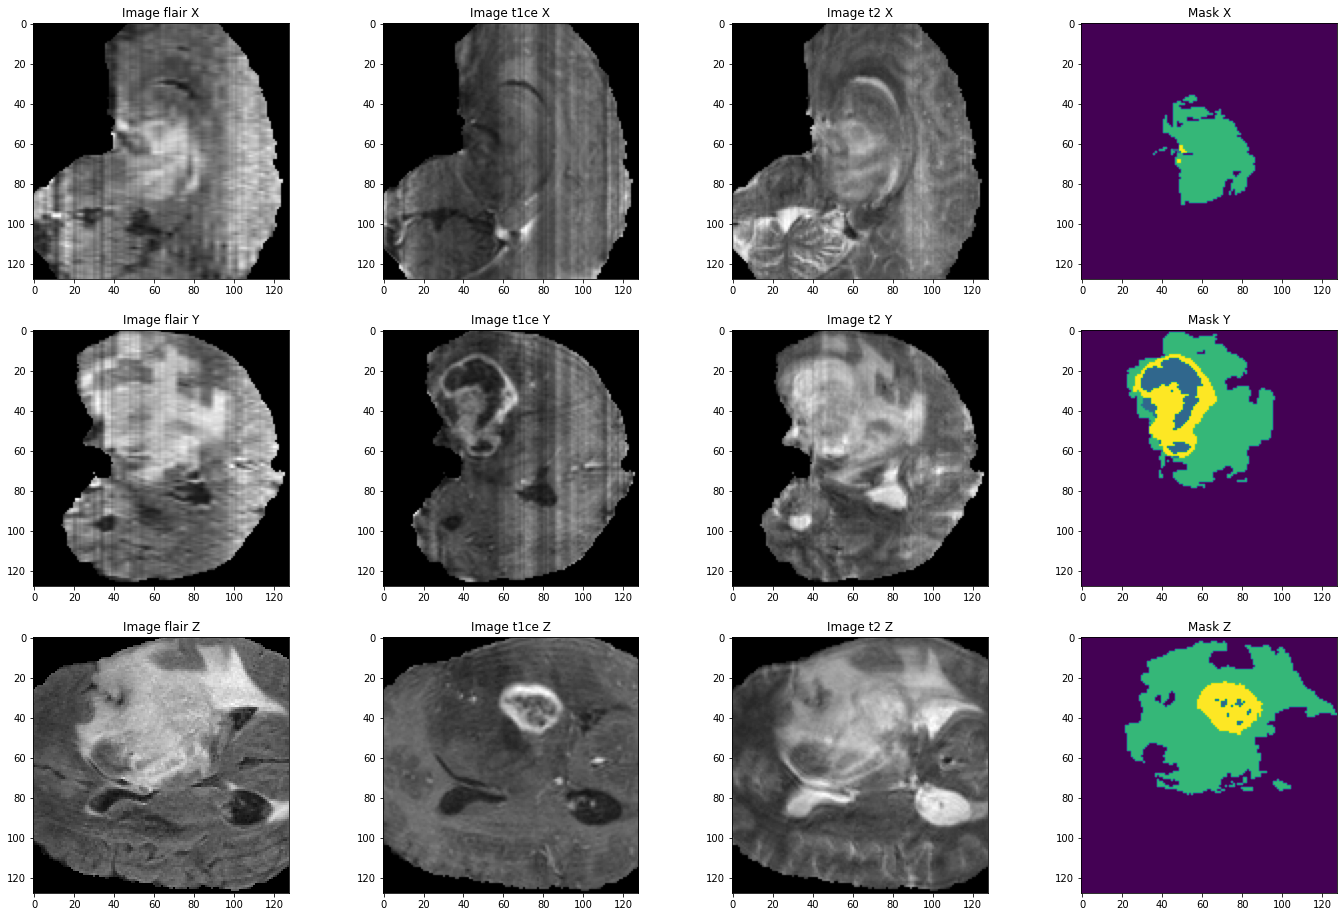

In [ ]:
#Test the generator

train_img_dir = "/content/drive/MyDrive/Colab/train_and_val_data/train/images/"
train_mask_dir = "/content/drive/MyDrive/Colab/train_and_val_data/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(24, 16))

plt.subplot(3,4,1)
plt.imshow(test_img[n_slice,:,:, 0], cmap='gray')
plt.title('Image flair X')
plt.subplot(3,4,2)
plt.imshow(test_img[n_slice,:,:, 1], cmap='gray')
plt.title('Image t1ce X')
plt.subplot(3,4,3)
plt.imshow(test_img[n_slice,:,:, 2], cmap='gray')
plt.title('Image t2 X')
plt.subplot(3,4,4)
plt.imshow(test_mask[n_slice,:,:])
plt.title('Mask X')

plt.subplot(3,4,5)
plt.imshow(test_img[:,n_slice,:, 0], cmap='gray')
plt.title('Image flair Y')
plt.subplot(3,4,6)
plt.imshow(test_img[:,n_slice,:, 1], cmap='gray')
plt.title('Image t1ce Y')
plt.subplot(3,4,7)
plt.imshow(test_img[:,n_slice,:, 2], cmap='gray')
plt.title('Image t2 Y')
plt.subplot(3,4,8)
plt.imshow(test_mask[:,n_slice,:])
plt.title('Mask Y')

plt.subplot(3,4,9)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair Z')
plt.subplot(3,4,10)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce Z')
plt.subplot(3,4,11)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2 Z')
plt.subplot(3,4,12)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask Z')

plt.show()


## U-Net


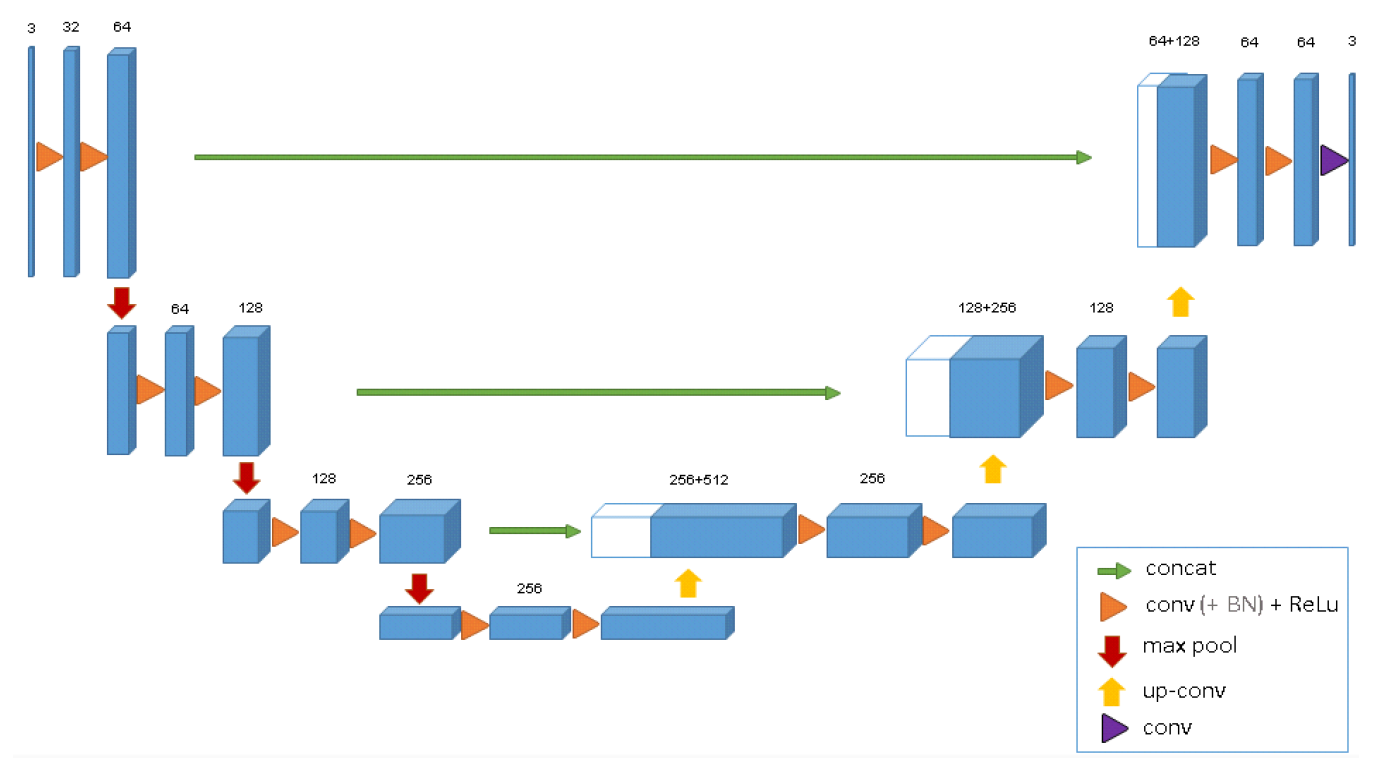

In [ ]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    # s = inputs
   
    #Contraction path
    conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    
    conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
     
    conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
     
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
     
    conv5 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv5)
    
    #Expansive path 
    up6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv6)
     
    up7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv7)
     
    up8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(0.1)(conv8)
    conv8 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv8)
     
    up9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv9)
     
    conv10 = Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv9)
     
    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    return model
    

In [ ]:
#Test
model = unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

## Training Part

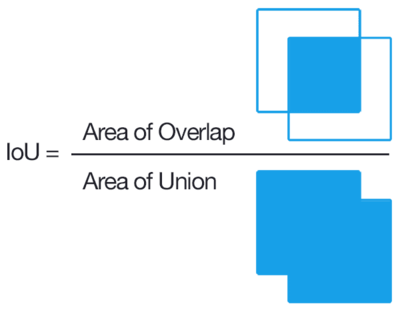

### For train and val data 7

In [ ]:
batch_size = 2

img_dir = '/content/drive/MyDrive/Colab/train_and_val_data7/train/images/'
img_list = sorted(os.listdir(img_dir))

masks_dir = '/content/drive/MyDrive/Colab/train_and_val_data7/train/masks/'
masks_list = sorted(os.listdir(masks_dir))

datagen = imageLoader(img_dir, img_list, masks_dir, masks_list, batch_size)
img,mask = datagen.__next__()


val_img_dir = '/content/drive/MyDrive/Colab/train_and_val_data7/val/images/'
val_img_list = sorted(os.listdir(val_img_dir))

val_masks_dir = '/content/drive/MyDrive/Colab/train_and_val_data7/val/masks/'
val_masks_list = sorted(os.listdir(val_masks_dir))

val_datagen = imageLoader(val_img_dir, val_img_list, val_masks_dir,  val_masks_list, batch_size)
val_img,val_mask = val_datagen.__next__()


wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
loss = dice_loss + (1 * focal_loss)   # Loss function dice_loss and focal_loss

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)  # Adam optimizer

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

# print(f'image shape : {img.shape}')
# print(f'Val image shape : {val_img.shape}')
# print(f'mask shape : {mask.shape}')
# print(f'Val mask shape : {val_mask.shape}')

model.compile(optimizer=optim, loss=loss, metrics=metrics)

steps_per_epoch=len(img_list)//batch_size
validation_steps = len(val_img_list)//batch_size


In [ ]:
history=model.fit(datagen, 
                  epochs=50, 
                  verbose = 1, 
                  steps_per_epoch=steps_per_epoch, 
                  validation_data=val_datagen, 
                  validation_steps=validation_steps)

### For train and val data 1

In [ ]:
## Load Model
my_model_2 = load_model('/content/drive/MyDrive/Colab/models/brats_3d_model_1.h5/', 
                      custom_objects={'dice_loss_plus_1focal_loss': loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
batch_size = 2

img_dir = '/content/drive/MyDrive/Colab/train_and_val_data1/train/images/'
img_list = sorted(os.listdir(img_dir))

masks_dir = '/content/drive/MyDrive/Colab/train_and_val_data1/train/masks/'
masks_list = sorted(os.listdir(masks_dir))

datagen = imageLoader(img_dir, img_list, masks_dir, masks_list, batch_size)
img,mask = datagen.__next__()


val_img_dir = '/content/drive/MyDrive/Colab/train_and_val_data1/val/images/'
val_img_list = sorted(os.listdir(val_img_dir))

val_masks_dir = '/content/drive/MyDrive/Colab/train_and_val_data1/val/masks/'
val_masks_list = sorted(os.listdir(val_masks_dir))

val_datagen = imageLoader(val_img_dir, val_img_list, val_masks_dir,  val_masks_list, batch_size)
val_img,val_mask = val_datagen.__next__()

steps_per_epoch=len(img_list)//batch_size
validation_steps = len(val_img_list)//batch_size

In [ ]:
history=my_model_2.fit(datagen, 
                  epochs=1, 
                  verbose = 1, 
                  steps_per_epoch=steps_per_epoch, 
                  # callbacks=callbacks, 
                  validation_data=val_datagen, 
                  validation_steps=validation_steps)

46/46 [==============================] - 248s 5s/step - loss: 0.8744 - accuracy: 0.9723 - iou_score: 0.4442 - val_loss: 0.8620 - val_accuracy: 0.9681 - val_iou_score: 0.4920


In [ ]:
if os.path.isfile('/content/drive/MyDrive/Colab/models/brasts_3d_model_2.h5') is False:
  model.save('/content/drive/MyDrive/Colab/models/brasts_3d_model_2.h5')

## Prediction

In [ ]:
## Retraining the model for 1 epoch.
my_model = load_model('/content/drive/MyDrive/Colab/models/brats_3d_model_1.h5', 
                      custom_objects={'dice_loss_plus_1focal_loss': loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})


history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_datagen,
          validation_steps=validation_steps,
          )



In [ ]:
#For predictions you do not need to compile the model, so ...
my_model = load_model('/content/drive/MyDrive/Colab/models/brats_3d_model_1.h5', 
                      compile=False)




In [ ]:
val_img_dir = '/content/drive/MyDrive/Colab/train_and_val_data4/val/images/'
val_img_list = sorted(os.listdir(val_img_dir))

val_masks_dir = '/content/drive/MyDrive/Colab/train_and_val_data4/val/masks/'
val_masks_list = sorted(os.listdir(val_masks_dir))


In [ ]:
## Mean IOU
batch_size=8 
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_masks_dir, val_masks_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#Predict on a few test images, one at a time

img_num = 132
# random.randrange()
# We cannot use random because of data split in train and val.

test_img = np.load("/content/drive/MyDrive/Colab/train_and_val_data4/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/Colab/train_and_val_data4/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

# n_slice=random.randint(0, test_prediction_argmax.shape[2])
# print(n_slice)

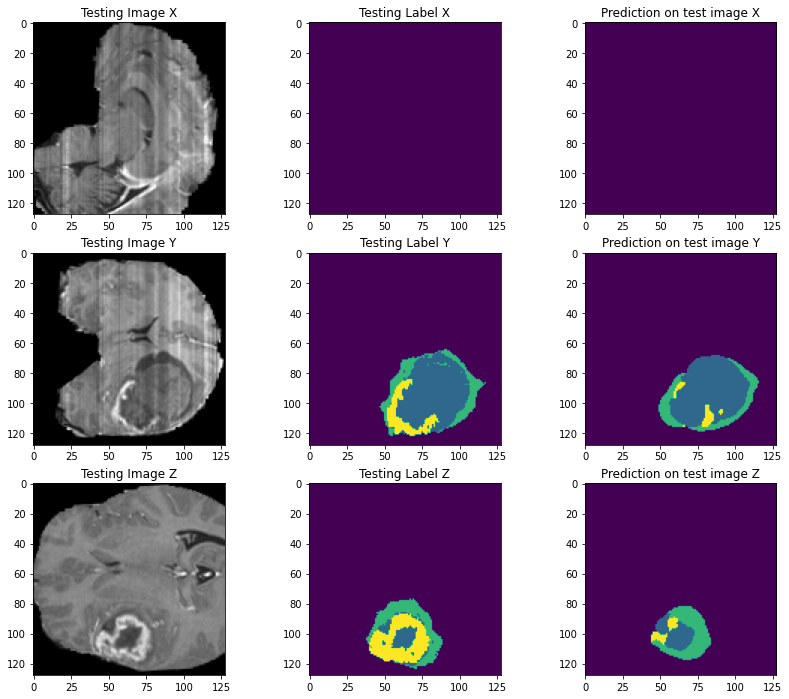

In [ ]:
## Pyplot

n_slice = 60
plt.figure(figsize=(14, 12))
plt.subplot(331)
plt.title('Testing Image X')
plt.imshow(test_img[n_slice,:,:,1], cmap='gray')
plt.subplot(332)
plt.title('Testing Label X')
plt.imshow(test_mask_argmax[n_slice,:,:])
plt.subplot(333)
plt.title('Prediction on test image X')
plt.imshow(test_prediction_argmax[n_slice,:,:])

plt.subplot(334)
plt.title('Testing Image Y')
plt.imshow(test_img[:,n_slice,:,1], cmap='gray')
plt.subplot(335)
plt.title('Testing Label Y')
plt.imshow(test_mask_argmax[:,n_slice,:])
plt.subplot(336)
plt.title('Prediction on test image Y')
plt.imshow(test_prediction_argmax[:,n_slice,:])

plt.subplot(337)
plt.title('Testing Image Z')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(338)
plt.title('Testing Label Z')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(339)
plt.title('Prediction on test image Z')
plt.imshow(test_prediction_argmax[:,:, n_slice])


plt.show()